In [49]:
#!pip install missingno

In [50]:
#!pip install openpyxl

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import missingno

In [52]:
# Load a sheet into a DataFrame by its name
df = pd.read_excel('files/titanic3.xlsx')
# See basic info about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


We can already see that all column names are lowercase and have no spaces in them so we do not need to make any changes to that. We may change the naming of the columns later on but for now these names are clear enough.

In [53]:
# Let's do some data exploration by looking at the first and last few rows of our dataframe
df.head(6)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"


In [54]:
df.tail(6)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1303,3,0,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C,NaN,NaN,NaN
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN


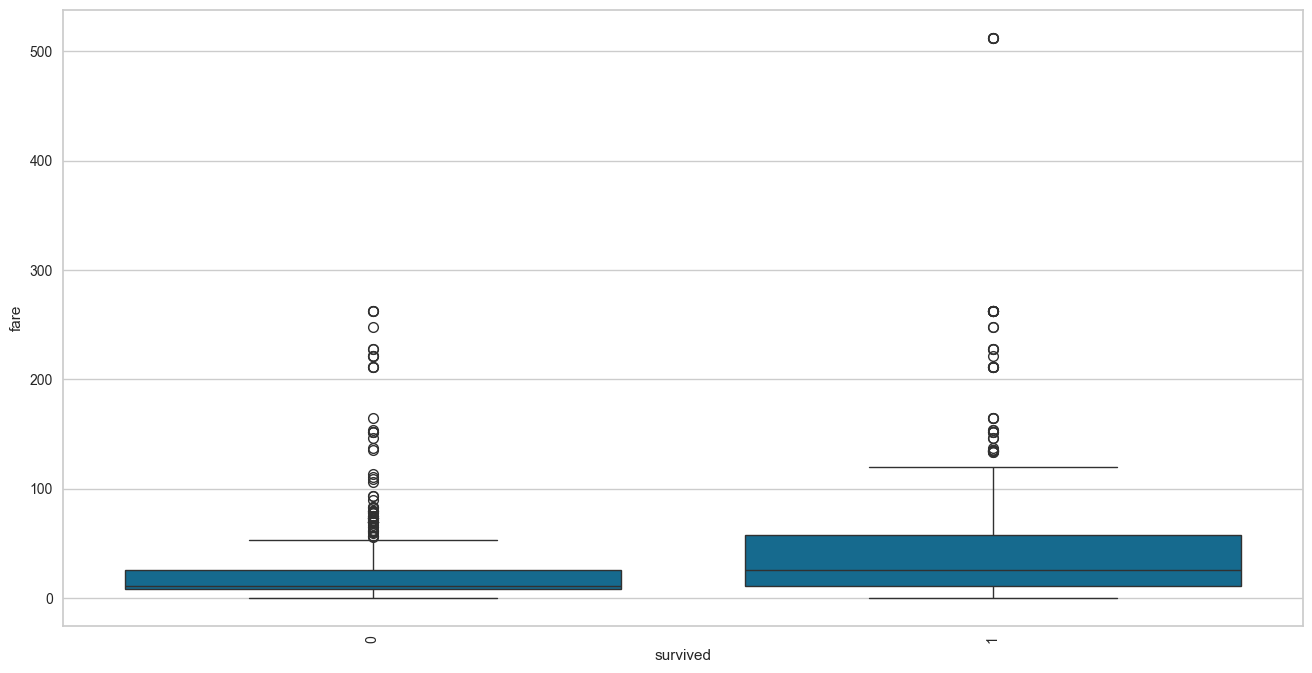

In [55]:
#Let's check our data for outliers in the regarding the people who survived and how much they paid
data = pd.concat([df['survived'], df['fare']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=df['survived'], y=df['fare'], data=data)
plt.xticks(rotation=90);

It is clear that there are outliers that need to be fixed.

In [56]:
# Let's see who are the people that have paid more than 500
df[df['fare'] > 500]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
49,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Austria-Hungary / Germantown, Philadelphia, PA"
50,1,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Germantown, Philadelphia, PA"
183,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,3,NaN,NaN
302,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,3,NaN,NaN


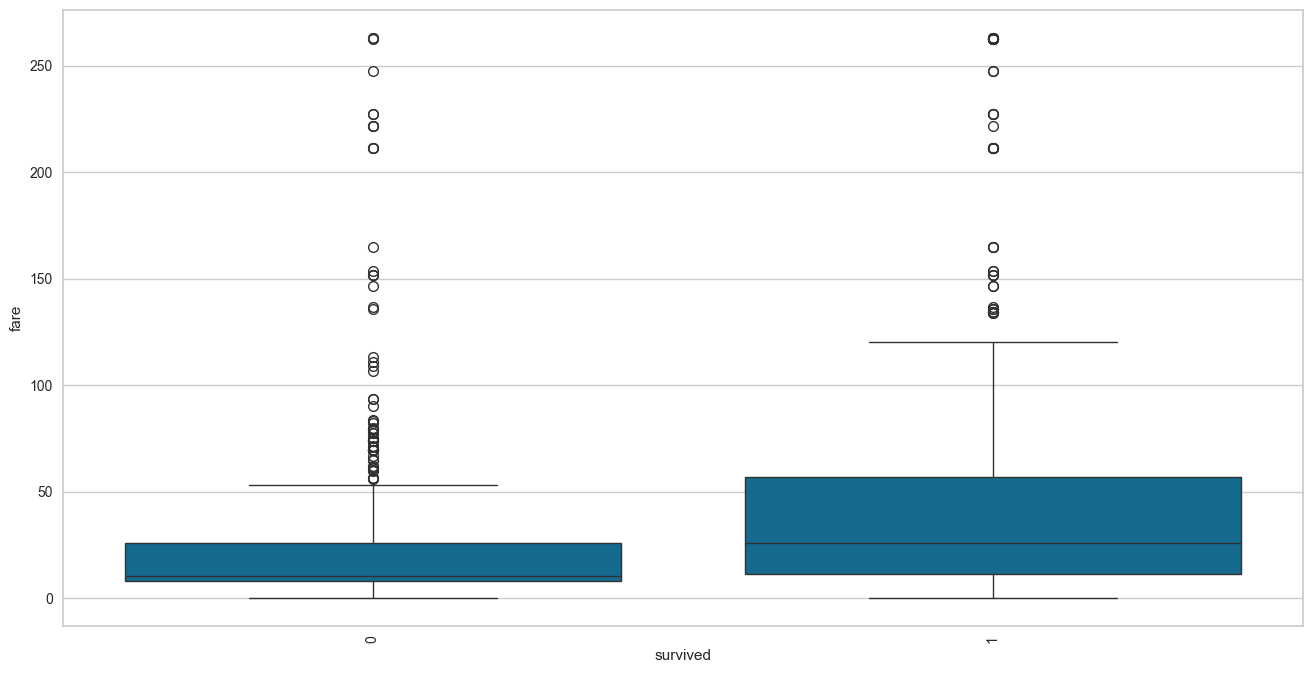

In [57]:
# We are going to change these outliers to the mean price that has been paid by the other passengers, we could do this by simply changing
# the fare price of these passengers but let's use the technique that would be used when there are more than a few outliers
# We use the outlier detection and removal technique

# Calculate the IQR (InterQuartile Range) for the fare column
Q1 = df['fare'].quantile(0.25)
Q3 = df['fare'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bound for outliers, (sidenote, normally the multiplier used to calculate the lower and upper bound is around 1.5
# but this would cause the identification of normal data as outliers resulting in a lot of good data to be lost because it is flagged as an
# outlier. This is why we use such a high multiplier value.
lower_bound = Q1 - 10 * IQR
upper_bound = Q3 + 10 * IQR

# Filter the data to exclude outliers
df = df[(df['fare'] >= lower_bound) & (df['fare'] <= upper_bound)]

# We again check for outliers using the same boxplot as used before
data = pd.concat([df['survived'], df['fare']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=df['survived'], y=df['fare'], data=data)
#fig.axis(ymin=0, ymax=300);
plt.xticks(rotation=90);

We can now see that we have gotten rid of the outliers and the highest fare that was paid is now around 270.

In [58]:
# The following thing we can do is to check how many empty rows each feature/column has.
df.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            0
cabin        1012
embarked        2
boat          822
body         1184
home.dest     561
dtype: int64

In [59]:
# This can form a problem if a certain column has way less data compared to the rest, let's check this
df.count()

pclass       1304
survived     1304
name         1304
sex          1304
age          1041
sibsp        1304
parch        1304
ticket       1304
fare         1304
cabin         292
embarked     1302
boat          482
body          120
home.dest     743
dtype: int64

<Axes: >

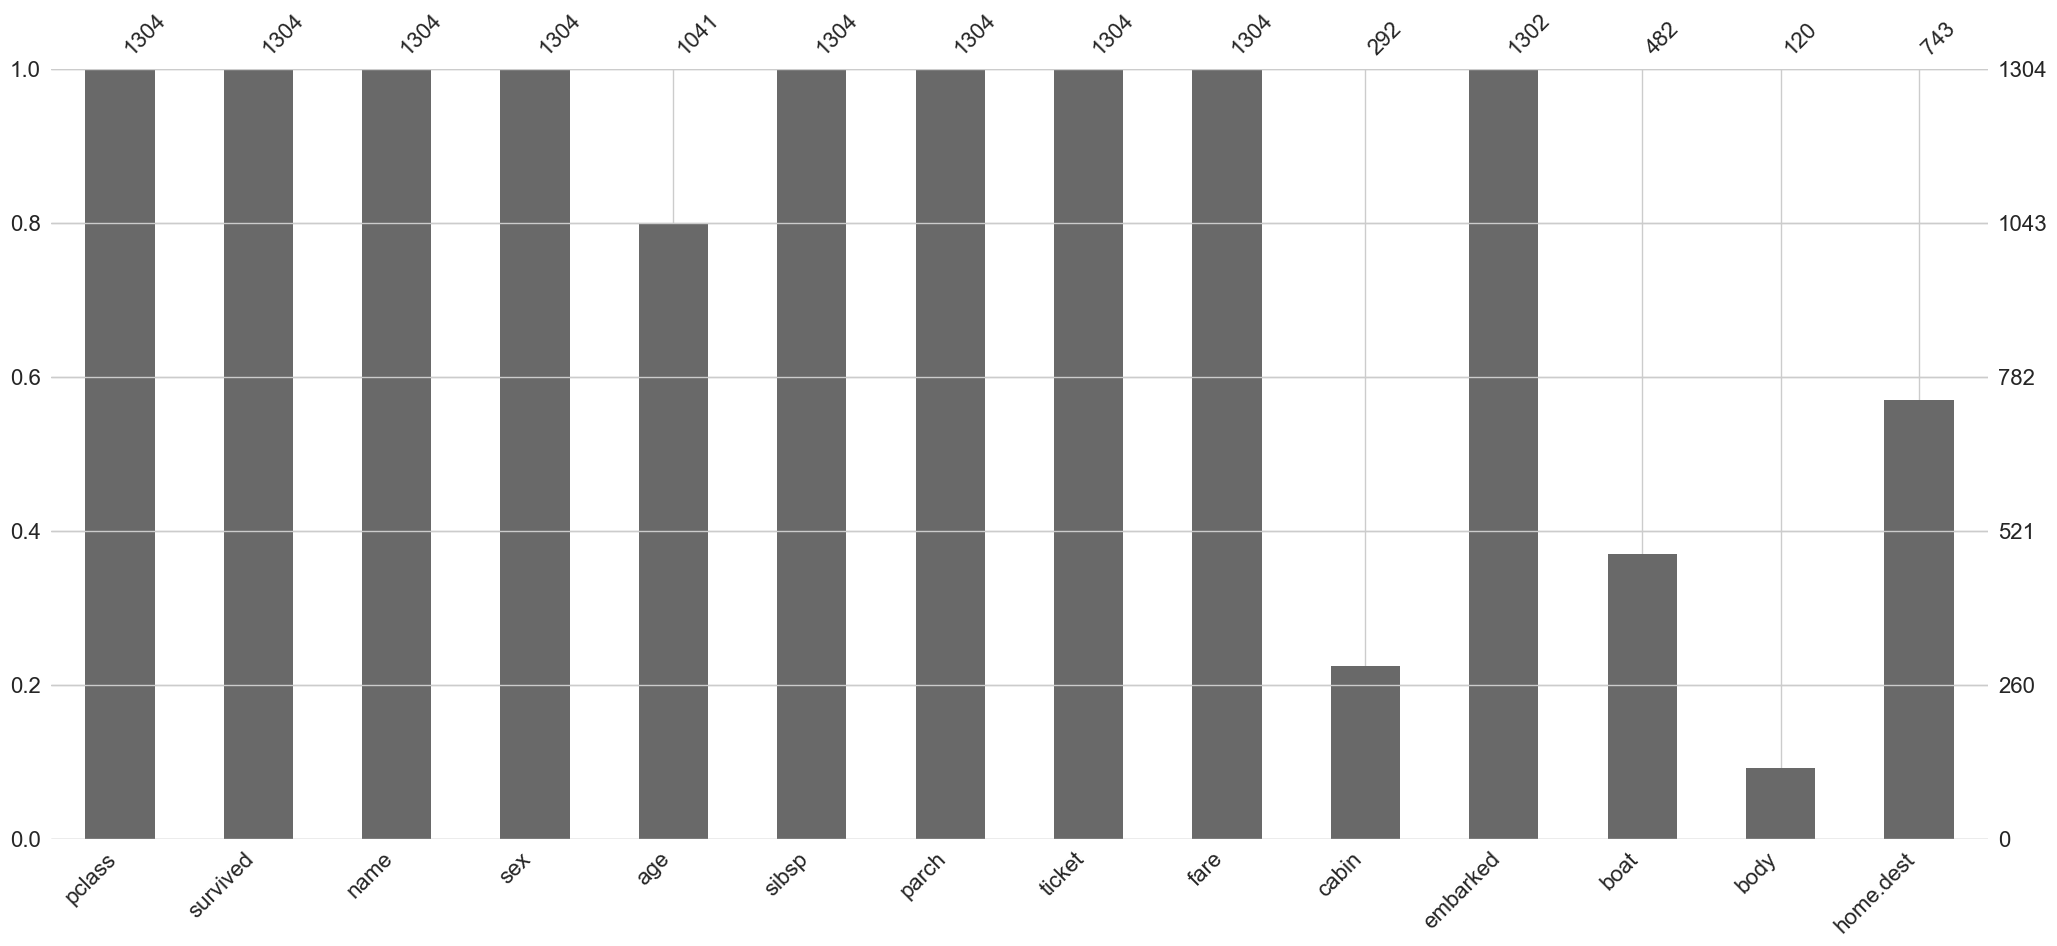

In [60]:
# We can even visualize this using the missingno library which helps to give a quick overview of your dataset completeness.
import missingno as msno 
msno.bar(df) 

Age has some null values resulting in a slighty lower amount of data.
Cabin is low because only the rich could afford one so that makes sense.
Boat is low because only people who survived have a value there and even then not every survivor has a value.
Body is low because it immediatly eliminates anyone that survived but still only a small amount of bodies were found.
Only about half of all home destinations are known.

Let's take a look at the name column

In [61]:
print(df['name'].head(5))
print(df['name'].tail(5))

0                      Allen, Miss. Elisabeth Walton
1                     Allison, Master. Hudson Trevor
2                       Allison, Miss. Helen Loraine
3               Allison, Mr. Hudson Joshua Creighton
4    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
Name: name, dtype: object
1304         Zabour, Miss. Hileni
1305        Zabour, Miss. Thamine
1306    Zakarian, Mr. Mapriededer
1307          Zakarian, Mr. Ortin
1308           Zimmerman, Mr. Leo
Name: name, dtype: object


We can see this includes both the first and last name but also the title.
Lets split these 3 apart into seperate columns.

In [62]:
df['firstname']=df['name'].str.split(r'[,.]', expand=True)[2]
df['title']=df['name'].str.split(r'[,.]', expand=True)[1]
df['lastname']=df['name'].str.split(r'[,.]', expand=True)[0]

We do not need the name column anymore and so we drop it

In [63]:
df.drop('name', axis = 1, inplace = True)

Let's take a look at the amount of times the different titles occur.

In [64]:
df.title.value_counts()

 Mr              754
 Miss            259
 Mrs             196
 Master           61
 Rev               8
 Dr                8
 Col               4
 Mlle              2
 Ms                2
 Major             2
 Capt              1
 Sir               1
 Dona              1
 Jonkheer          1
 the Countess      1
 Don               1
 Mme               1
 Lady              1
Name: title, dtype: int64

We can see that a lot of titles only occur once but have the same meaning so we change some of these titles so that it is more clear.

In [65]:
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royal",
    "Don":        "Royal",
    "Sir" :       "Royal",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royal",
    "Dona":       "Royal",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royal"
}
# Strip leading and trailing spaces from the 'title' column
df['title'] = df['title'].str.strip()

# Now, apply the mapping to change original values to new values
df['title'] = df['title'].map(normalized_titles)

# Verify the unique values in the 'title' column
print(df['title'].unique())

# Now, run df['title'].value_counts()
value_counts_result = df['title'].value_counts()
print(value_counts_result)

['Miss' 'Master' 'Mr' 'Mrs' 'Officer' 'Royal']
Mr         754
Miss       261
Mrs        199
Master      61
Officer     23
Royal        6
Name: title, dtype: int64


Let's fix the null values in age. First we check what the mean age is.

In [66]:
mean_age = df['age'].mean()
mean_age.round(0)

30.0

We have multiple options now on how we can fix the null values.
One could be to just simply remove the rows containing null values but 263 rows is a lot of good data to just simply delete.
Another option could be to replace the null values with the average age but what would happen then is that when we visualise our data there would be a spike with the amount of people that are exactly the mean age.
What we do instead is to replace the null values with the mean value but instead of assigning a fixed value we give random values but when you calculate the mean of those values they result in the mean of the current age.

We can also make sure that the people

In [67]:
# Calculate the mean age for non-null values
mean_age = df['age'].mean()

# Calculate the standard deviation of the age column, which will be used to generate random but believable age values
std_age = df['age'].std()

# Create a mask to identify rows with "Master" or "Miss" in the "title" column
master_miss_mask = (df['title'] == 'Master') | (df['title'] == 'Miss')

# Generate random values for rows with "Master" or "Miss" based on a different standard deviation
random_values_master_miss = np.random.normal(loc=0, scale=std_age * 0.5, size=master_miss_mask.sum())

# Shift the distribution to have the same mean as the original data
added_values_master_miss = random_values_master_miss + mean_age

# Update the 'age' column for rows with "Master" or "Miss" individually
master_miss_indices = df.index[master_miss_mask]
for i, index in enumerate(master_miss_indices):
    # Ensure that the age does not exceed 18
    age = min(added_values_master_miss[i], 18)
    df.loc[index, 'age'] = age

# For all other missing values, use the previously calculated random values
random_values = np.random.normal(loc=0, scale=std_age, size=df['age'].isna().sum())
added_values = random_values + mean_age

# Update the 'age' column for all other missing values individually
other_indices = df.index[~master_miss_mask & df['age'].isna()]
for i, index in enumerate(other_indices):
    df.loc[index, 'age'] = added_values[i]

# Change the datatype of the age column from float to int
df['age'] = df['age'].astype(int)

# Check if all null values have been replaced
print(df['age'].isna().sum())

0


In [68]:
# Next we take a look at the cabin column
head = df['cabin'].head(5)
tail = df['cabin'].tail(5)
print(head)
print(tail)

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object
1304    NaN
1305    NaN
1306    NaN
1307    NaN
1308    NaN
Name: cabin, dtype: object


 As seen in the missingno visualisation more than 70% of rows have a null value in this column.
 This however does not mean that we should drop this column due to insufficient data, the fact that people don't have a cabin is still valuable information that we can use to
 train our model. 
 For the people that do have a cabin it is not important to know which exact cabin they had (C22, D7 etc.) so we make this column a boolean, all not null values 1 and all null values 0.

 Of course there are other methods of dealing with null values, interpolation, forward and backward fill can be other options that should be considered. Sadly these methods would not work well in this case because the neighbouring rows are not correlated to eachother which would mean that changing this data to neighbouring rows would result in inaccurate data and a worse model for predictions. So let's continue with the boolean method we talked about earlier.


In [69]:
# We fill missing values with 0
df['cabin'].fillna(0, inplace=True)

# Replace non-null values with 1 without having problems because there are non-numerical values
df['cabin'] = df['cabin'].apply(lambda x: 1 if x != 0 else x)
print(df['cabin'].head(5))
print(df['cabin'].tail(5))

0    1
1    1
2    1
3    1
4    1
Name: cabin, dtype: int64
1304    0
1305    0
1306    0
1307    0
1308    0
Name: cabin, dtype: int64


In [70]:
# There are 2 null values in the embarked column, because it is such a small amount of data we simply change it to the value 'Q'
# which stands for Queenstown
df['embarked'] = df['embarked'].replace(np.nan, 'Q')

In [71]:
# Let's check if this worked and there are no null values left
df['embarked'].isna().sum()

0

In [72]:
# We take a look at the boat column next
head = df['boat'].head(5)
tail = df['boat'].tail(5)
print(head)
print(tail)

0      2
1     11
2    NaN
3    NaN
4    NaN
Name: boat, dtype: object
1304    NaN
1305    NaN
1306    NaN
1307    NaN
1308    NaN
Name: boat, dtype: object


Like seen in the missingno visualisation and in the head and tail of the database above there are a lot of null values which is logical because a lot of people didn't survive which means they weren't able to get on a boat. Let's see if there are any survivors who did not have a boat or if there are people who did have a boat but still didn't survive.

In [73]:
# We check how many people that did survive still have a null value in the boat column.
count = len(df[(df['survived'] == 1) & df['boat'].isna()])
print('Amount of people that survived but did not have a boat: ' + str(count))
# We see that there are 0 survivors who still have a null value which means that all the null values are of people who did not survive
# Let's check this just to be sure
count = len(df[(df['survived'] == 0) & df['boat'].notnull()])
print('Amount of people that did not survive but did have a boat: ' + str(count))


Amount of people that survived but did not have a boat: 23
Amount of people that did not survive but did have a boat: 9


As we can see there are still exceptions, if there were none we could've simply used the survived column to change the data in the boat column.
The question is now what we will do with the null values in the boat column. We have a lot of options here, drop all rows with null values, interpolation, forward fill and backward fill etc.

But just like with the cabin column, the null values still tell us something so dropping the rows would be a bad option, especially since there are so many. Interpolation would not be smart because there isn't a large correlation between neigbouring rows so using neigbouring values would just give us wrong data. This is also why forward fill and backward fill would not work.

We decide to simply make a boolean of the row making all not null values 1 and all null values 0. The number or letter that the boat has is not important for the training of the dataset so changing the not null values from (12,D,8,A etc.) to 1 does not matter.

In [74]:
df['boat'].fillna(0, inplace=True)

# Replace non-null values with 1 without having problems because there are non-numerical values
df['boat'] = df['boat'].apply(lambda x: 1 if x != 0 else x)
print(df['boat'].head(5))
print(df['boat'].tail(5))

0    1
1    1
2    0
3    0
4    0
Name: boat, dtype: int64
1304    0
1305    0
1306    0
1307    0
1308    0
Name: boat, dtype: int64


In [75]:
print(df['body'].head(5))
print(df['body'].tail(5))

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64
1304    328.0
1305      NaN
1306    304.0
1307      NaN
1308      NaN
Name: body, dtype: float64


The body column has over 90% null values. This is logical because only people that died can have a not null value in this column. Let's check if this is truly the case.
Let's also check how many bodies were found in total and the percentage of dead peoples bodies that were found.

In [76]:
count = len(df[(df['survived'] == 1) & df['body'].notnull()])
print('Amount of people that did survive but a body was still found: ' + str(count))

count = len(df[df['body'].notnull()])
print('Amount of bodies found in total: ' + str(count))

total_amount_dead = (df['survived'] == 0).sum()
print('Amount of people that did not survive: ' + str(total_amount_dead))

percentage = count/total_amount_dead
print('Percentage of dead peoples bodies that were found:  ' + str(percentage.round(3)))

Amount of people that did survive but a body was still found: 0
Amount of bodies found in total: 120
Amount of people that did not survive: 808
Percentage of dead peoples bodies that were found:  0.149


Again the number that the body was given does not matter and there is no correlation between the neighbouring rows so we change the data to a boolean, 1 for not null and 0 for null values.

In [77]:
df['body'].fillna(0, inplace=True)

# Replace non-null values with 1 without having problems because there are non-numerical values
df['body'] = df['body'].apply(lambda x: 1 if x != 0 else x)
# We change the datatype from float to int
df['body'] = df['body'].astype(int)
print(df['body'].head(5))
print(df['body'].tail(5))

0    0
1    0
2    0
3    1
4    0
Name: body, dtype: int32
1304    1
1305    0
1306    1
1307    0
1308    0
Name: body, dtype: int32


Lets check the home destination column next.

In [78]:
print(df['home.dest'].head(5))
print(df['home.dest'].tail(5))

0                       St Louis, MO
1    Montreal, PQ / Chesterville, ON
2    Montreal, PQ / Chesterville, ON
3    Montreal, PQ / Chesterville, ON
4    Montreal, PQ / Chesterville, ON
Name: home.dest, dtype: object
1304    NaN
1305    NaN
1306    NaN
1307    NaN
1308    NaN
Name: home.dest, dtype: object


Like seen in the visualisation and the output above there are still a lot of null values. Especially in the 3rd class. Let's visualize this. 

(-1.099999992320727, 1.0999998663551604, -1.09999985568244, 1.0999999113130292)

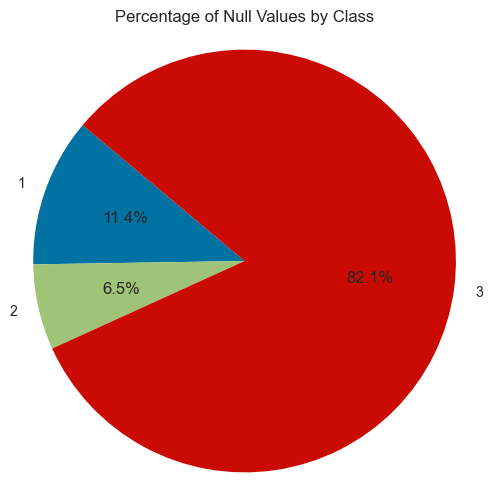

In [79]:
grouped = df.groupby('pclass')['home.dest'].apply(lambda x: x.isnull().mean())

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(grouped, labels=grouped.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Null Values by Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


We can clearly see that there is a very large difference between the amount of home destinations not known in 1st and 2nd class compared to 3rd class. This changes how many options we have for this column. We cannot leave it is as it is because our model would become biased towards 1st and 2nd class. We cannot drop all null value rows because it would delete 82% of all the people in 3rd class. We cannot fill in random places because than we change our data too much. We cannot look at neigbouring values because neigbouring rows do not have a correlation.

Our only option is to drop this column because it can only have a negative impact on our model.

In [80]:
df.drop('home.dest', axis = 1, inplace = True)


Let's again have an overall look at our dataframes amount of rows per column

<Axes: >

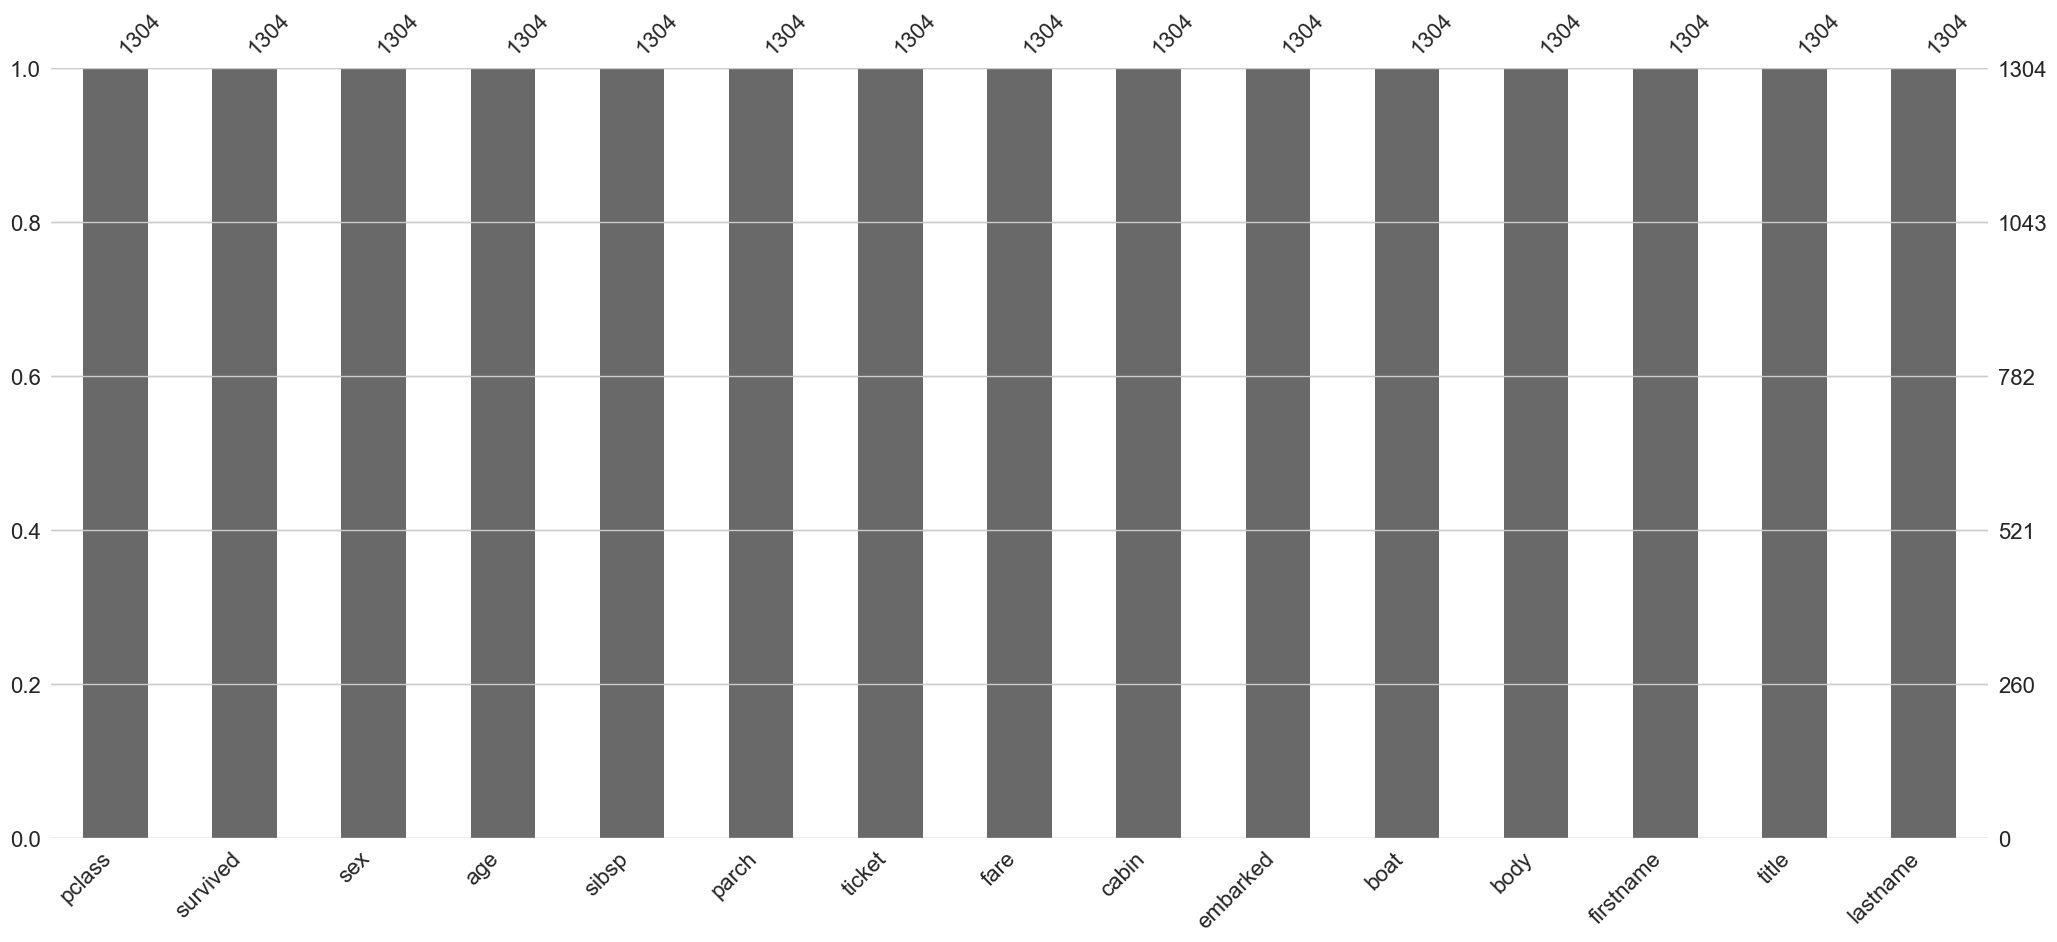

In [81]:
import missingno as msno 
msno.bar(df) 

We can now see that we have fixed all columns which had less values than other columns.


Let's check the basic datatypes of our columns again.

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1304 non-null   int64  
 1   survived   1304 non-null   int64  
 2   sex        1304 non-null   object 
 3   age        1304 non-null   int32  
 4   sibsp      1304 non-null   int64  
 5   parch      1304 non-null   int64  
 6   ticket     1304 non-null   object 
 7   fare       1304 non-null   float64
 8   cabin      1304 non-null   int64  
 9   embarked   1304 non-null   object 
 10  boat       1304 non-null   int64  
 11  body       1304 non-null   int32  
 12  firstname  1304 non-null   object 
 13  title      1304 non-null   object 
 14  lastname   1304 non-null   object 
dtypes: float64(1), int32(2), int64(6), object(6)
memory usage: 185.1+ KB


We see that there are some columns with the wrong datatype. Let's change that.

In [83]:
df['survived'] = df['survived'].astype(bool)
df['boat'] = df['boat'].astype(bool)
df['body'] = df['body'].astype(bool)
df['embarked'] = str(df['embarked'])

In [84]:
encoder = ce.OrdinalEncoder(cols=['sex'])
df_encoded = encoder.fit_transform(df)
df_encoded
# 1 = female, 2 = male

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,firstname,title,lastname
0,1,True,1,18,0,0,24160,211.3375,1,0 S\n1 S\n2 S\n3 S\n4 ...,True,False,Elisabeth Walton,Miss,Allen
1,1,True,2,18,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,True,False,Hudson Trevor,Master,Allison
2,1,False,1,18,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Helen Loraine,Miss,Allison
3,1,False,2,30,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,False,True,Hudson Joshua Creighton,Mr,Allison
4,1,False,1,25,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Hudson J C (Bessie Waldo Daniels),Mrs,Allison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,False,1,18,1,0,2665,14.4542,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,True,Hileni,Miss,Zabour
1305,3,False,1,18,1,0,2665,14.4542,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Thamine,Miss,Zabour
1306,3,False,2,26,0,0,2656,7.2250,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,True,Mapriededer,Mr,Zakarian
1307,3,False,2,27,0,0,2670,7.2250,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Ortin,Mr,Zakarian


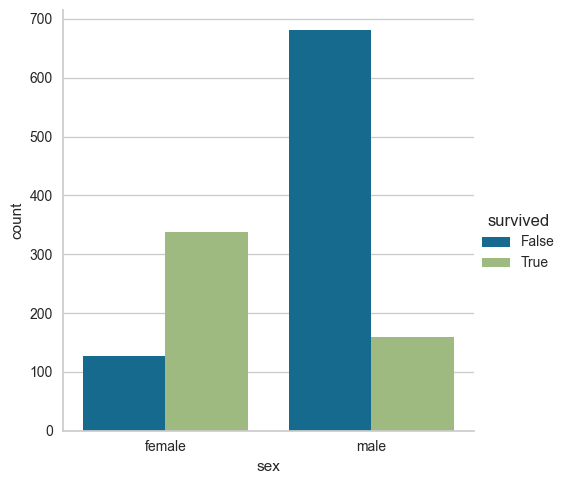

In [85]:
sns.catplot(x='sex', hue = 'survived', kind='count', data= df)
#sns.catplot(x='survived', hue = 'sex', kind='count', data= df)

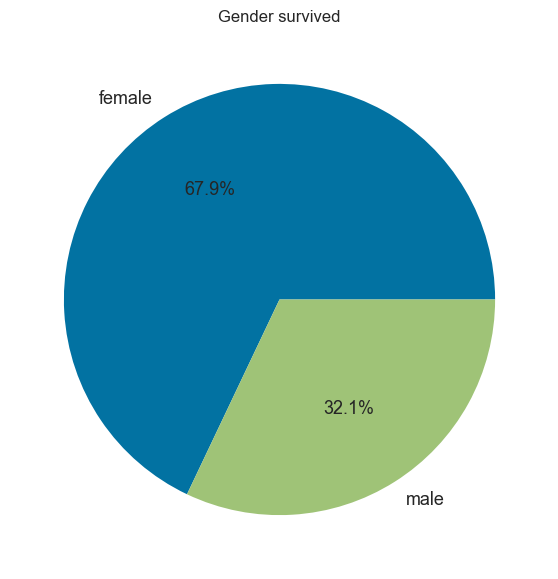

In [86]:
survived_sex= df.groupby('sex')['survived'].sum()
plt.figure(figsize=(7,7))
plt.title('Gender survived')
plt.pie(survived_sex,labels=['female','male'],autopct='%1.1f%%', textprops={'fontsize':13})
plt.show()

# Pycaret model

Install needed modules to use pycaret.

In [87]:
#!pip install pandas numpy
#!pip install pycaret

Import libraries.

In [88]:
from pycaret.classification import *

## Setup the Pycaret environment
Initialize the training environment and create the transformation pipeline to prepare the data for modeling and deployment. Target is set on survived because this is what we want to predict.

In [89]:

s = setup(df_encoded, target = 'survived', session_id = 123)

,Description,Value
0,Session id,123
1,Target,survived
2,Target type,Binary
3,Original data shape,"(1304, 15)"
4,Transformed data shape,"(1304, 20)"
5,Transformed train set shape,"(912, 20)"
6,Transformed test set shape,"(392, 20)"
7,Numeric features,7
8,Categorical features,5
9,Preprocess,True


## Compare the models
Here we compare the outcomes of all the models. Every highest score is marked in yellow. We can see that Logistic Regression scores overall the best.

In [90]:
# functional API
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9791,0.9943,0.9566,0.9884,0.9719,0.9554,0.9561,0.0180
ridge,Ridge Classifier,0.9791,0.0000,0.9566,0.9884,0.9719,0.9554,0.9561,0.0130
lda,Linear Discriminant Analysis,0.9386,0.9744,0.8733,0.9638,0.9149,0.8672,0.8713,0.0130
nb,Naive Bayes,0.9342,0.9805,0.9653,0.8779,0.9183,0.8636,0.8679,0.0130
et,Extra Trees Classifier,0.9123,0.9781,0.8275,0.9376,0.8773,0.8096,0.8152,0.0320
svm,SVM - Linear Kernel,0.8915,0.0000,0.8765,0.8675,0.8639,0.7751,0.7858,0.0140
rf,Random Forest Classifier,0.8377,0.9387,0.6919,0.8575,0.7621,0.6419,0.6530,0.0340
knn,K Neighbors Classifier,0.7785,0.8379,0.6545,0.7420,0.6919,0.5205,0.5260,0.0260
dt,Decision Tree Classifier,0.7150,0.6567,0.4143,0.6946,0.5046,0.3333,0.3589,0.0140
ada,Ada Boost Classifier,0.7029,0.7848,0.3771,0.7067,0.4784,0.3032,0.3380,0.0220


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## Test the best model
Now we want to test the best model (logistic regression) on our dataset.
In the column 'prediction_label' we can see if our model predicted if the person survived or not. 1 = survived & 0 = dead.
In the column 'prediction_score' we can see how sure our model thinks it has predicted the right outcome.

In [91]:
predict_model(best, data=df_encoded)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9755,0.9968,0.9536,0.9813,0.9673,0.9477,0.9479


,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,firstname,title,lastname,survived,prediction_label,prediction_score
0,1,1,18,0,0,24160,211.337494,1,0 S\n1 S\n2 S\n3 S\n4 ...,True,False,Elisabeth Walton,Miss,Allen,True,1,0.9951
1,1,2,18,1,2,113781,151.550003,1,0 S\n1 S\n2 S\n3 S\n4 ...,True,False,Hudson Trevor,Master,Allison,True,1,0.9695
2,1,1,18,1,2,113781,151.550003,1,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Helen Loraine,Miss,Allison,False,0,0.8410
3,1,2,30,1,2,113781,151.550003,1,0 S\n1 S\n2 S\n3 S\n4 ...,False,True,Hudson Joshua Creighton,Mr,Allison,False,0,0.9925
4,1,1,25,1,2,113781,151.550003,1,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Hudson J C (Bessie Waldo Daniels),Mrs,Allison,False,0,0.6909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,18,1,0,2665,14.454200,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,True,Hileni,Miss,Zabour,False,0,0.9555
1305,3,1,18,1,0,2665,14.454200,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Thamine,Miss,Zabour,False,0,0.8868
1306,3,2,26,0,0,2656,7.225000,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,True,Mapriededer,Mr,Zakarian,False,0,0.9945
1307,3,2,27,0,0,2670,7.225000,0,0 S\n1 S\n2 S\n3 S\n4 ...,False,False,Ortin,Mr,Zakarian,False,0,0.9833


Get the accuracy to compare it later on.

## Save model
Finally we can save the model in our files folder.

In [92]:
save_model(best, 'files/titanic_pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pclass', 'sex', 'age', 'sibsp',
                                              'parch', 'fare', 'cabin'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Transforme...
                                                               han

If I want to reuse this model I can simply load it from my files folder

In [93]:
loaded_model = load_model('files/titanic_pycaret_model')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=C:\Users\kieran\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['pclass', 'sex', 'age', 'sibsp',
                                             'parch', 'fare', 'cabin'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='depreca...
                                                             

### In previous model we used the dataset with feature boat and body included. Obviously when someone was on a boat their survival chance is greater then someone who was in the cold water. Also when they found the body of a person, this person obviously died. This means that when we include these 2 features in our dataset the model will almost only look at those 2 features to make predictions. To see the differnce in performance we will now create a model without these 2 features.

Here we are going to exclude our column boat and body from our dataset.

In [94]:
df_exclude = df_encoded
df_exclude = df_exclude.drop(['boat', 'body'], axis=1)
df_exclude

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,firstname,title,lastname
0,1,True,1,18,0,0,24160,211.3375,1,0 S\n1 S\n2 S\n3 S\n4 ...,Elisabeth Walton,Miss,Allen
1,1,True,2,18,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,Hudson Trevor,Master,Allison
2,1,False,1,18,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,Helen Loraine,Miss,Allison
3,1,False,2,30,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,Hudson Joshua Creighton,Mr,Allison
4,1,False,1,25,1,2,113781,151.5500,1,0 S\n1 S\n2 S\n3 S\n4 ...,Hudson J C (Bessie Waldo Daniels),Mrs,Allison
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,False,1,18,1,0,2665,14.4542,0,0 S\n1 S\n2 S\n3 S\n4 ...,Hileni,Miss,Zabour
1305,3,False,1,18,1,0,2665,14.4542,0,0 S\n1 S\n2 S\n3 S\n4 ...,Thamine,Miss,Zabour
1306,3,False,2,26,0,0,2656,7.2250,0,0 S\n1 S\n2 S\n3 S\n4 ...,Mapriededer,Mr,Zakarian
1307,3,False,2,27,0,0,2670,7.2250,0,0 S\n1 S\n2 S\n3 S\n4 ...,Ortin,Mr,Zakarian


### Create and test model

In [95]:

s_exclude = setup(df_exclude, target = 'survived', session_id = 123)

# functional API
best_exclude = compare_models()
print(best_exclude)

predict_model(best_exclude, data=df_exclude)

measures_exclude = pull()

save_model(best_exclude, 'files/titanic_exluded_pycaret_model')

loaded_exclude_model = load_model('files/titanic_exluded_pycaret_model')
print(loaded_exclude_model)


,Description,Value
0,Session id,123
1,Target,survived
2,Target type,Binary
3,Original data shape,"(1304, 13)"
4,Transformed data shape,"(1304, 18)"
5,Transformed train set shape,"(912, 18)"
6,Transformed test set shape,"(392, 18)"
7,Numeric features,7
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8191,0.8715,0.6946,0.8076,0.7449,0.6062,0.6120,0.0230
nb,Naive Bayes,0.7434,0.8004,0.5396,0.7221,0.6130,0.4284,0.4414,0.0130
et,Extra Trees Classifier,0.7270,0.7861,0.4906,0.7144,0.5729,0.3846,0.4041,0.0300
ridge,Ridge Classifier,0.7226,0.0000,0.4179,0.7460,0.5333,0.3576,0.3894,0.0130
rf,Random Forest Classifier,0.7083,0.7829,0.4034,0.7067,0.5115,0.3256,0.3526,0.0330
knn,K Neighbors Classifier,0.6930,0.7016,0.5132,0.6182,0.5583,0.3269,0.3318,0.0190
gbc,Gradient Boosting Classifier,0.6809,0.6295,0.3056,0.6886,0.4189,0.2425,0.2824,0.0270
lda,Linear Discriminant Analysis,0.6777,0.7257,0.2767,0.6902,0.3898,0.2255,0.2697,0.0150
dt,Decision Tree Classifier,0.6776,0.6097,0.3256,0.6584,0.4323,0.2426,0.2733,0.0130
ada,Ada Boost Classifier,0.6743,0.6652,0.3928,0.6516,0.4652,0.2584,0.2896,0.0230


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9164,0.9727,0.8286,0.9448,0.8829,0.8184,0.8226


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=C:\Users\kieran\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['pclass', 'sex', 'age', 'sibsp',
                                             'parch', 'fare', 'cabin'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='depreca...
        

### Lets compare the 2 models.
We can see that all the measures of the model with the boat & body columns included in the dataset scored better then the model without them. This is what we thought because boat & body are strong indicators to predict if a preson survived or not.

In [96]:
measures

NameError: name 'measures' is not defined

In [97]:
measures_exclude

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9164,0.9727,0.8286,0.9448,0.8829,0.8184,0.8226


# Self chosen model

# Gradient Boosting Regressor

I think that Gradient Boosting Regressor is a good technique to use for the Titanic dataset. They create an ensemble of weak learners to build a strong predictive model. These algorithms are known for their high predictive accuracy and can handle missing data and outliers gracefully.

# With boat and body

First we need to do all of our imports so we can actually use the gradient boosting regressor

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

Now we are going to define the features wich we want to use to make a prediction and the value we acctually want to predict. We place these in the variables x and y.

In [111]:
features = ['pclass','sex','age','sibsp','parch','fare','cabin','boat','body','ticket', 'embarked','firstname','title','lastname']
x = df_encoded[features]
y = df_encoded['survived']

The gradient boosting regressor can't handle text values. But in our dataset we do have text values. So with this line off code we are going to give all of these text values a number.

In [112]:
X = pd.get_dummies(x, columns=['ticket', 'embarked','firstname','title','lastname'], drop_first=True)

Then we are going to split the dataset into a test and a training set.

In [113]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now we are going to fit our model. We are using 100 estimators and random state 0.

In [114]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb_regressor.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='squared_error',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_iter_no_change=None,
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Here we are going to use our test set to make a predictions using the model we just created. We save it in a temporary variable because our model returns float values, but we want to have boolean values (or 0 and 1).

In [115]:
y_pred_prob = gb_regressor.predict(x_test)

To convert our float values to a boolean (or 0 and 1) we use the code below. everything that the model predicts as higher than 0.5 will be true and lower than 0.5 will be false.

In [116]:
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

Now we are going to print the actual values and the predicted values so we can see how well our model did.

In [117]:
result_df = pd.DataFrame({'Actual': y_test[:25], 'Predicted': y_pred[:25]})

print(result_df)

      Actual  Predicted
1157   False          0
978     True          1
787    False          0
1023    True          1
316    False          0
482     True          1
5       True          1
645     True          1
420    False          0
430     True          1
286    False          0
828    False          0
31      True          1
678    False          0
970     True          1
57      True          1
715    False          0
835    False          0
911    False          0
998    False          0
946    False          0
1025    True          1
1244    True          1
829    False          0
805     True          1


After this we are going to save our model in the files folder.

In [118]:
save_model(gb_regressor, 'files/titanic_ChosenWithBoat_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pclass', 'sex', 'age', 'sibsp',
                                              'parch', 'fare', 'cabin'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  Transforme...
                                            criterion='friedman_ms

If we want to reuse this model we can simply load it from the files folder.

In [119]:
loaded_model = load_model('files/titanic_ChosenWithBoat_model')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=C:\Users\kieran\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['pclass', 'sex', 'age', 'sibsp',
                                             'parch', 'fare', 'cabin'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='depreca...
                                           criterion='friedma

# Without Boat and Body

I have created another model but without the body and boat values. This is because these values will have a verry big impact on the result. For example if you don't have a boat the chances of survival are almost 0. So our model will almost always say that you won't survive if you don't have a boat. So with this model we can see hopw well it works without these almost certain values.

In [120]:
features = ['pclass','sex','age','sibsp','parch','fare','cabin','ticket', 'embarked','firstname','title','lastname']
x = df_encoded[features]
y = df_encoded['survived']

### Create and test model

In [121]:
X = pd.get_dummies(x, columns=['ticket', 'embarked','firstname','title','lastname'], drop_first=True)

#Split into training and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Fit model
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb_regressor.fit(x_train, y_train)

#Make predictions using test set
y_pred_prob = gb_regressor.predict(x_test)

#Convert float values to 0 or 1
threshold = 0.5
y_pred_no_boat = (y_pred_prob > threshold).astype(int)

#Print actual and predicted values
result_df = pd.DataFrame({'Actual': y_test[:25], 'Predicted': y_pred_no_boat[:25]})
print(result_df)

#Save model in folder
save_model(gb_regressor, 'files/titanic_Chosen_model')

#Load model from folder
loaded_model = load_model('files/titanic_Chosen_model')
print(loaded_model)

      Actual  Predicted
1157   False          0
978     True          0
787    False          0
1023    True          1
316    False          0
482     True          1
5       True          0
645     True          0
420    False          0
430     True          1
286    False          1
828    False          0
31      True          0
678    False          0
970     True          0
57      True          1
715    False          0
835    False          0
911    False          0
998    False          0
946    False          1
1025    True          1
1244    True          1
829    False          0
805     True          1
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=C:\Users\kieran\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['pclass', 'sex', 'age', 'sibsp',
                       

### Let's compare the models

As we can see are the predictions of the model with the boat much better than the predictions without.

In [122]:
result_df = pd.DataFrame({'Actual': y_test[:25],'Predicted with boat': y_pred[:25], 'Predicted without boat': y_pred_no_boat[:25]})
print(result_df)

      Actual  Predicted with boat  Predicted without boat
1157   False                    0                       0
978     True                    1                       0
787    False                    0                       0
1023    True                    1                       1
316    False                    0                       0
482     True                    1                       1
5       True                    1                       0
645     True                    1                       0
420    False                    0                       0
430     True                    1                       1
286    False                    0                       1
828    False                    0                       0
31      True                    1                       0
678    False                    0                       0
970     True                    1                       0
57      True                    1                       1
715    False  